# Rule-based control of the solar home (Python)

This is the simplest control scheme of the solar home, implemented in Python. It can be used as an example of how to use the solar home test bench in this language. Rule-based control yields a good baseline performance for comparing more advanced energy management methods.

See also:
* [Python_rule-based-optim.ipynb](Python_rule-based-optim.ipynb): a slightly more complex rule-based control, with one parameter to be optimized using training data
* [Julia_rule-based.ipynb](../julia_rule-based/Julia_rule-based.ipynb): an equivalent example in Julia

Pierre Haessig, July 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Fixed costs taken from:
https://www.greenmatch.co.uk/blog/2018/07/solar-battery-storage-system-cost

Import solarhome utility module `benchutils`, using `bu` as a short alias.

## 2. Rule based control

control rules:

* storage should follow the net load as much as possible: $P_{sto} = -P_{nl} = P_{sun} - P_{load} $
* if empty, use grid instead
* if full, curtail the excess of production

inputs: $P_{sun}$, $P_{load}$ and storage state $E_{sto}$

Outputs: $P_{sto}$, $P_{grid}$, $P_{curt}$

def: net load: $P_{nl} = P_{load} - P_{sun}$

* if $P_{nl}>0$ (load > sun)
  * if battery not empty: battery discharge to follow net load $P_{sto} = -P_{nl} <0 $, $P_{grid} = 0$.
  * if battery is empty, use the grid instead: $P_{grid} = P_{nl}$
* if $P_{nl}<0$ (sun > load)
  * if battery not full: battery charges to absorbe net production $P_{sto} = -P_{nl} > 0$, $P_{grid} = 0$.
  * if battery is full, curtail the excess of production: $P_{curt} = -P_{nl}$, so that $P_{sun} - P_{curt} = P_{pv} = P_{load}$. $P_{grid} = 0$

In [2]:
def control(P_sun, P_load, E_sto, dt, E_rated):
    """""
    P_sun: Generated power from PV (kW)
    P_load: Building load demand (kW)
    E_sto: Energy stored in the battery (kWh)
    dt: Derivate of time step (Hours)
    
    """""
    P_nl = P_load - P_sun # Net load -> Power needed by building from grid or battery (or combination)
    # outputs:
    P_sto = 0. # The power flowing into the battery (kW)
    P_grid = 0. # The power imported from the grid (kW)
    P_curt = 0. # The power exported to the grid (kW)
    
    E_next = E_sto - P_nl*dt # Energy stored in the battery at the end of current timestep (kWh)
    
    if P_nl>0: # (load > sun) -> Try to discharge the battery to the building load, if energy is available
        #TODO: Limit rate of discharge of battery
        E_next = E_next if E_next>0. else 0.
        P_sto = (E_next - E_sto)/dt # <0 # Calculate power flowing out of the battery
        P_grid = P_nl + P_sto # Calculate power taken from the grid as load power minus the batter discharge power
    else: # (load <= sun) -> Try to charge the battery
        E_next = E_next if E_next<E_rated else E_rated # Calculate battery charge state. Don't charge if full.
        P_sto = (E_next - E_sto)/dt # >0 # Calculate power flowing into the battery
        P_curt = -P_nl - P_sto#Calculate exported power: difference between net load and power flowing into battery
    return P_sto, P_grid, P_curt

## 3. Solar home simulation

## Method
#### ~~Select type of battery~~
#### ~~Get lifespan of battery~~
#### ~~Get install cost of battery~~
#### ~~Calculate amortized cost of battery per kWh per year~~
#### ~~Get cost of energy per kWh~~
#### ~~Choose initial and step size for battery (e.g. 1 kW with a step size of 0.5 kW)~~
#### ~~For each step size, calculate cost of battery plus cost of import~~
#### ~~Choose step size at which to run and stop optimisation~~
#### Include export revenue
#### Select step size with lowest total cost (optimal battery size)
#### Check optimisation results with a range of test loads

In [3]:
def amortize_batt_cost(cost_per_kwh, life_cycles):
    discharge_cycles_per_day = 1
    days_per_year = 365
    cycles_per_year = discharge_cycles_per_day * days_per_year
    _battery_life_years = life_cycles / cycles_per_year
    _amortized_battery_cost_kwh = cost_per_kwh / _battery_life_years
    return _amortized_battery_cost_kwh

In [4]:
def check_result(E_sto, E_rated, digits=3):
    """Check that battery charge is non-negative and not over capacity"""
    try:
        assert round( E_sto, digits ) >= 0.0, 'Battery charge state is negative'
        assert round ( E_sto, digits ) <= round( E_rated, digits ), 'Battery charge state is greater than capacity'
    except(AssertionError):
        print(f'E_sto: {E_sto}\tE_rated: {E_rated}')
        raise

In [5]:
def initialise_results_arrays(length, intial_charge_percent=0):
    P_sto = np.zeros(length)
    E_sto = np.zeros(length+1)
    P_grid = np.zeros(length)
    P_curt = np.zeros(length)
    E_sto[0]= intial_charge_percent
    return {'P_sto':P_sto, 'E_sto':E_sto, 'P_grid':P_grid, 'P_curt':P_curt}

In [6]:
def run_control(results, timestep, size, generation, _load, _dt):
    assert isinstance(results, dict)
    for k, v in results.items(): assert isinstance(v, np.ndarray)
        
    results['P_sto'][timestep], results['P_grid'][timestep], results['P_curt'][timestep] = \
        control(generation.values[timestep], _load.values[timestep], results['E_sto'][timestep], dt=_dt, E_rated=size)
    
    results['E_sto'][timestep+1] = results['E_sto'][timestep] + results['P_sto'][timestep] * _dt
    
    check_result( results['E_sto'][timestep+1], size )
    
    return results

In [7]:
def evaluate_results(results, amortized_battery_cost_kwh, batt_size, IMPORT_COST_KWH, _generation, _load):
    results['E_sto'] = results['E_sto'][:-1]
    P_pv = _generation - results['P_curt']
    P_nl = _load - _generation

    battery_cost = batt_size * amortized_battery_cost_kwh
#     print('Assuming timestep is one hour for kWh calculation')
    grid_power = results['P_grid'].sum()
#     print(f'grid power: {grid_power}')
    import_cost = grid_power * IMPORT_COST_KWH
    total_cost = battery_cost + import_cost
    costs = {'batt_size':batt_size, 'battery_cost':battery_cost,
             'import_cost':import_cost, 'total_cost':total_cost}
    print('.', end='', flush=True)
#     print(costs)
    return results, costs

### Optimise battery size

In [29]:
def stop_or_continue(cost, prev_cost, keep_iterating):
    
    if prev_cost:
        diff_cost, prev_cost = cost - prev_cost, cost
    else:
        diff_cost, prev_cost = 0, cost
    
    keep_iterating = (keep_iterating+1) if  diff_cost <= 0 else (keep_iterating-1)

    return prev_cost, keep_iterating

In [34]:
def simulate_battery_perfomance(load, generation, _batt_cost, import_cost, dt):
    rv = []
    size, prev_cost, keep_iterating = 0, 0, 1
    
    while keep_iterating:

        results = initialise_results_arrays(len(load))

        for hour in range(len(load)):
            results = run_control(results, hour, size, generation, load, dt)

        results, costs = evaluate_results(results, _batt_cost, size, import_cost, generation, load)
        rv.append(costs)
            
        prev_cost, keep_iterating = stop_or_continue( costs['total_cost'], prev_cost, keep_iterating )

        size += 1
    
    return pd.DataFrame(rv).set_index('batt_size')

In [35]:
load_profiles = pd.read_pickle('examples/load_and_generation.pkl')
load_profiles.sample()

,17.64_1kWp_generation_kWh,load_kWh,import_kWh,export_kWh
2019-07-23 11:00:00,3.791968,14.452967,10.660999,0.0


.......................

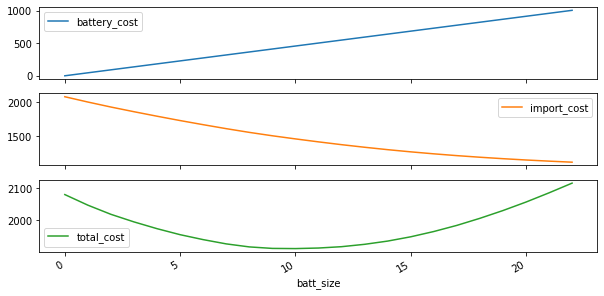

In [36]:
res = simulate_battery_perfomance(
    load = load_profiles.iloc[:,1],
    generation = load_profiles.iloc[:,0],
    _batt_cost = amortize_batt_cost(cost_per_kwh=500, life_cycles=4000),
    import_cost = 0.20,
    dt = 1)
ax = res.plot(subplots=True, figsize=(10,5))